In [1]:
# Standard library imports:
import os
import numpy as np
import matplotlib.pyplot as plt
import lattice
from scipy.fft import fft, fftfreq

# Plot setup:
textprops = {"ha": "right", "va": "top"}
if os.uname().sysname == 'Darwin':
    %matplotlib inline

In [2]:
# Data input:
uj_vs_s = {
    2: 5.5425,
    5: 7.78888,
    7.5: 8.91949,
    10: 9.775,
    12.5: 10.4694,
    15: 11.0568,
    20: 12.0196,
    22: 12.3482,
    24: 12.6522,
    25: 12.7961,
    30: 13.4492,
    35: 14.014,
    }

# Invert:
s_vs_uj = {s: uj for (uj, s) in uj_vs_s.items()}

In [3]:
# Calculate Wannier functions:

Varr = sorted(uj_vs_s.values())  # lattice depth in units of the recoil energy
size = 100  # number of lattice sites
qarr = lattice.quasimomenta(size)  # quasimomenta
n = 0  # band index
Npoint=500
xrange=100
xarr = np.linspace(-xrange/2, xrange/2 ,Npoint)  # real-space position

wannier_functions = []
for V in Varr:
    _, bs = lattice.eigenproblem(V, qarr, bands=n, kohns_phase=True)
    wf = lattice.wannier(xarr, bs)
    wannier_functions.append(np.real(wf))

dx = xarr[1] - xarr[0]

In [4]:
# Calculate TF:

T=xrange/Npoint; # sampling distance in position space
karr = fftfreq(Npoint, T)[:Npoint//2] # generating the array in the momentum space for FT calculation

FTwannier_functions = []
for i in range(len(Varr)):
    FTwannier_functions.append(fft(wannier_functions[i]))
    FTwannier_functions[i]=FTwannier_functions[i]/np.max(FTwannier_functions[i])
    FTwannier_functions[i]=FTwannier_functions[i][:len(FTwannier_functions[i])//2]
    FTwannier_functions[i]=np.concatenate((FTwannier_functions[i][::-1],FTwannier_functions[i][1:]))

karr=np.concatenate((-karr[::-1],karr[1:])) # to have a symmetric plot centered on k=0

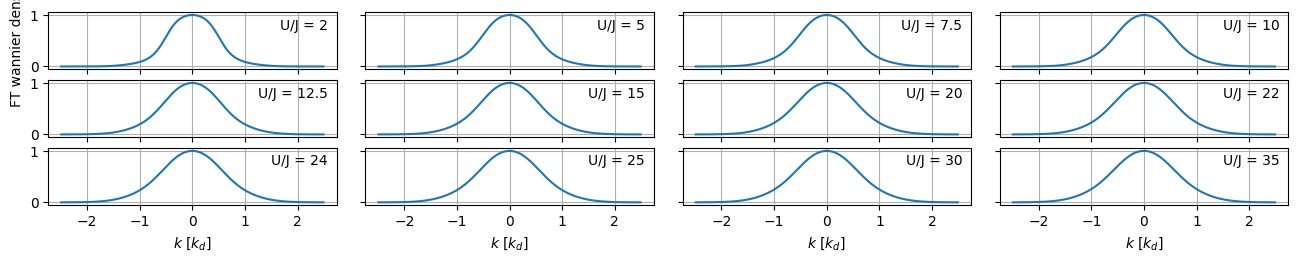

In [5]:
# Plot mod. square of TF:

fig, axes = plt.subplots(3, 4, figsize=(16, 2.5), sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(karr, np.abs(FTwannier_functions[i])**2)#,label='$s={}E_r$'.format(Varr[i]))
    # ax.plot(karr,np.exp(-karr**2*(4/np.sqrt(Varr[i]))),'--')#label='Approx. Gauss. $s={}E_r$'.format(Varr[0]))
    # ax.set_xlim(0,3)
    ax.set_xlabel('$k$ [$k_d$]')
    ax.grid()
    ax.text(.97, .9, f"U/J = {s_vs_uj[Varr[i]]}", textprops, transform=ax.transAxes)
axes.flatten()[0].set_ylabel("FT wannier density")
plt.subplots_adjust(wspace=.1)
#plt.ylabel('Density [a.u.]')

plt.show()

# Relating quantities measured in the FBZ to systemwide quantites

We measure $N_0 \equiv N_{\mathbf{k} = \mathbf{0}}$ and $N_{\mathrm{FBZ}}$ and want to relate these quantities to $N_{\mathrm{BEC}}$ and $N_{\mathrm{tot}}$ using the Wannier functions $w_{n, j}(x) = \sqrt{\frac{d}{2\pi}} \int_{\mathrm{FBZ}} \psi_{n, q}(x) e^{-ijqd}\mathrm{d}q$ where $j \in \mathbb{Z}$ corresponds to the index of the lattice site and $n \in \mathbb{N}$ to the lattice band. Their TF is denoted $\tilde{w}$.

$ \displaystyle  N_0 = |\tilde{w}(\mathbf{0})|^2$

$ \displaystyle N_{\mathrm{BEC}} = \sum_{\mathbf{k} \in \mathbb{N}k_d}|\tilde{w}(\mathbf{k})|^2$

$ \displaystyle N_{\mathrm{FBZ}} = \int_{-0.5k_d}^{0.5k_d}\mathrm{d}\mathbf{k}|\tilde{w}(\mathbf{k})|^2$

$ \displaystyle N_{\mathrm{tot}} = \int_{-\infty}^{\infty}\mathrm{d}\mathbf{k}|\tilde{w}(\mathbf{k})|^2$

In [13]:
# Calculate quantities:

dk = karr[1] - karr[0]

k_0_idx = np.where(karr==0)[0][0]
k_bec_idxs = np.where([i.is_integer() for i in karr])[0]
fbz_idxs = [i for i in range(len(karr)) if -0.5 <= karr[i] <= 0.5]

n_0 = np.zeros_like(Varr)
n_bec = np.zeros_like(Varr)
n_fbz = np.zeros_like(Varr)
n_tot = np.zeros_like(Varr)
f_c_fbz = np.zeros_like(Varr)
f_c_tot = np.zeros_like(Varr)

for i, _ in enumerate(Varr):

    n_0[i] = abs(FTwannier_functions[i][k_0_idx])**2
    n_bec[i] = sum(abs(FTwannier_functions[i][k_bec_idxs])**2)
    n_fbz[i] = sum(dk*abs(FTwannier_functions[i][fbz_idxs])**2)
    n_tot[i] = sum(dk*abs(FTwannier_functions[i][:])**2)
    f_c_fbz[i] = n_0[i] / n_fbz[i]
    f_c_tot[i] = n_bec[i] / n_tot[i]

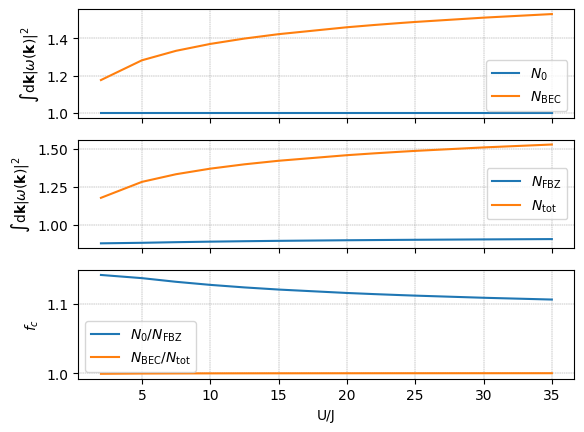

In [14]:
# Plot results as a function of U/J:

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(
    sorted(uj_vs_s.keys()),
    n_0,
    label=r'$N_0$'
    )
axs[0].plot(
    sorted(uj_vs_s.keys()),
    n_bec,
    label=r'$N_{\mathrm{BEC}}$'
    )
axs[1].plot(
    sorted(uj_vs_s.keys()),
    n_fbz,
    label=r'$N_{\mathrm{FBZ}}$'
    )
axs[1].plot(
    sorted(uj_vs_s.keys()),
    n_tot,
    label=r'$N_{\mathrm{tot}}$'
    )
axs[2].plot(
    sorted(uj_vs_s.keys()),
    f_c_fbz,
    label=r'$N_0 / N_{\mathrm{FBZ}}$'
    )
axs[2].plot(
    sorted(uj_vs_s.keys()),
    f_c_tot,
    label=r'$N_{\mathrm{BEC}} / N_{\mathrm{tot}}$'
    )
for idx, ax in enumerate(axs):
    if idx==len(axs)-1:
        ax.set_xlabel('U/J')
        ax.set_ylabel(r'$f_c$')
    else:
        ax.set_ylabel(r'$\int\mathrm{d}\mathbf{k} |\omega (\mathbf{k})|^2$')
    ax.legend()
    ax.set_axisbelow(True)    
    ax.xaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.grid(visible=True)

plt.show()